In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import os
from IPython.display import Audio
from enum import Enum
from typing import List, Tuple
import re

%matplotlib inline

In [3]:
# Establish the numeric regex parser for sorting spectrograph files.

pattern = re.compile(r'\d+', flags=re.DOTALL)

In [4]:
# Let's start by first establishing our data paths.
audio_path = Path(os.getcwd()).parent / 'data' / 'genres_original'
print([d for d in list(audio_path.iterdir())[:5]])
print('+'*50)
spectrograph_path = Path(os.getcwd()).parent / 'data' / 'images_original'
print([d for d in list(spectrograph_path.iterdir())[:5]])

[PosixPath('/home/altafuturis/Masters/sem3/smdm/MoodSick/data/genres_original/pop'), PosixPath('/home/altafuturis/Masters/sem3/smdm/MoodSick/data/genres_original/disco'), PosixPath('/home/altafuturis/Masters/sem3/smdm/MoodSick/data/genres_original/rock'), PosixPath('/home/altafuturis/Masters/sem3/smdm/MoodSick/data/genres_original/metal'), PosixPath('/home/altafuturis/Masters/sem3/smdm/MoodSick/data/genres_original/blues')]
++++++++++++++++++++++++++++++++++++++++++++++++++
[PosixPath('/home/altafuturis/Masters/sem3/smdm/MoodSick/data/images_original/pop'), PosixPath('/home/altafuturis/Masters/sem3/smdm/MoodSick/data/images_original/disco'), PosixPath('/home/altafuturis/Masters/sem3/smdm/MoodSick/data/images_original/rock'), PosixPath('/home/altafuturis/Masters/sem3/smdm/MoodSick/data/images_original/metal'), PosixPath('/home/altafuturis/Masters/sem3/smdm/MoodSick/data/images_original/blues')]


In [5]:
# For ease of accessibility, we will create an enum for the genres.

GENRE = Enum('GENRE', list([d.name for d in audio_path.iterdir()]))

In [6]:
# Now, we map the audio and spectrographs to these enum values. Here, 'audio' refers to the path where the
# audio files are located, and 'spec' refers to the path where the spectrograph images are located.

GENRE_MAP = {
    GENRE[a.name]: {'audio': a, 'spec': s} for (a, s) in zip(audio_path.iterdir(), spectrograph_path.iterdir())
}

In [7]:
# Printing out an example of the resultant map. This makes retrieving genre-specific 
# data much easier with the ENUM key.

GENRE_MAP[GENRE.blues]

{'audio': PosixPath('/home/altafuturis/Masters/sem3/smdm/MoodSick/data/genres_original/blues'),
 'spec': PosixPath('/home/altafuturis/Masters/sem3/smdm/MoodSick/data/images_original/blues')}

In [8]:
# Let's design some audio and image helper functions.

def get_random_samples(genre: GENRE, n: int = 5) -> Tuple[np.ndarray, np.ndarray]:
    
    def custom_sorter(p: Path, file_type: str):
        assert file_type in ['audio', 'spec']
        if file_type == 'audio':
            # Uses *.00000**.wav
            return int(str(p.name).split('.')[1])
        
        # Otherwise, uses a **00000**.png
        return int(re.search(pattern, str(p.name)).group())
    
    # Reference all the music in the genre.
    audio_files = np.array(
        sorted(
            list(GENRE_MAP[genre]['audio'].glob('*.wav')),
            key=lambda x: custom_sorter(x, 'audio')
        )
    )
    
    spectrograph_files = np.array(
        sorted(
            list(GENRE_MAP[genre]['spec'].glob('*.png')),
            key=lambda x: custom_sorter(x, 'spec')
        )
    ) 
    
    # Sample `n` instances uniformly from both and return them.
    # But both will be sampled differently! To fix that, let's sample indices.
    random_ix = np.random.choice(np.arange(len(audio_files)), n, replace=False)
    
    return audio_files[random_ix], spectrograph_files[random_ix]


def play_audio(file: Path, print_info: bool = False):
    if print_info:
        print(f"Toggle to play {file.name}")
        
    display(Audio(file))

    
def plot_graphs(spec_paths: np.ndarray):
    # Unlike audio, we can easily clump the graphs.
    n = len(spec_paths)
    
    ncols = 2
    nrows = n//2 if n%2 == 0 else (n//2) + 1
    
    # Create the subplots.
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12))
    
    # Flatten the axes and iterate.
    for ix, ax in enumerate(axes.flat):
        if ix < n:
            # Use a context manager to close the fpath.
            with Image.open(spec_paths[ix], 'r') as im:
                ax.imshow(im)
                ax.set_title(f'Spectrograph for {spec_paths[ix].name}')
        else:
            ax.set_visible(False)

    plt.show()

In [9]:
# Sanity testing.
audio, specs = get_random_samples(GENRE.rock, 3)

for sample in audio:
    play_audio(sample, print_info=True)

Toggle to play rock.00006.wav


Toggle to play rock.00025.wav


Toggle to play rock.00068.wav


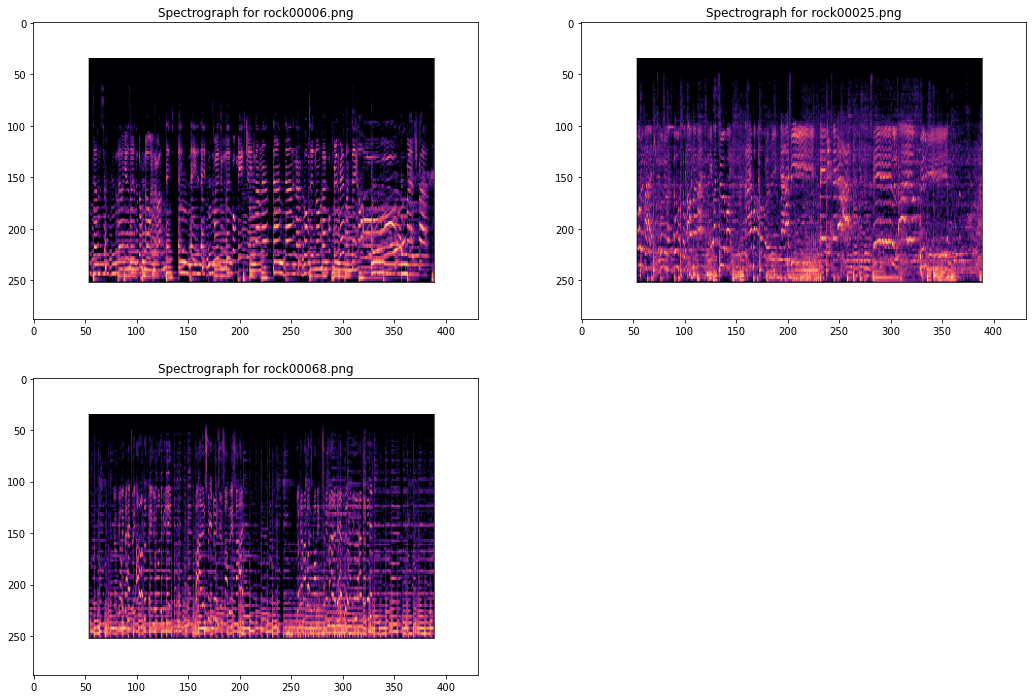

In [10]:
plot_graphs(specs)

In [11]:
# Cool! Now, we want to look at the metadata files.

metadata_30s = Path(os.getcwd()).parent / 'data' / 'features_30_sec.csv'
metadata_3s = Path(os.getcwd()).parent / 'data' / 'features_3_sec.csv'

m30df = pd.read_csv(metadata_30s)
m3df = pd.read_csv(metadata_3s)

In [12]:
display(m30df.head())
print("+"*50)
display(m3df.head())

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]

++++++++++++++++++++++++++++++++++++++++++++++++++


filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

In [13]:
# Oops, it looks like the creator forgot to upload the 3-second clips altogether. Oh well, we'll just
# work with the 30-second clips.

del metadata_3s
del m3df

In [14]:
# Let's print out the attributes
print(m30df.columns)

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

Let's go over the attributes and try to understand them first.

- `chroma_stft`: Chroma Short-Time Fourier Transform, which describes the pitch or tone of the audio clip
- `rms`: Root-Mean-Square, which describes the audio's energy
- `spectral_centroid`: Center-of-mass of the spectrograph, which is used to denote brightness in an audio clip
- `spectral_bandwidth`: Indicates the range of frequencies throughout the audio clip
- `rolloff`: Akin to percentiles or confidence scores, this metric denotes the point below which a certain percentage of frequency lies.
- `zero_crossing_rate`: Indicates the rate at which the frequency transitions from +ve -> -ve and vice versa
- `harmony`: Indicates the harmonic content in the audio clip via the Harmony-to-noise ratio
- `perceptr`: Indicates the perceptrum, which is a feature that denotes how the audio is perceived.
- `mfcc`: Mel-Frequency Ceptral Coefficients. These encode several spectral characteristics of the audio clip.

In [30]:
# Now that we have a brief understanding of the underlying features, let's try to do some data exploration!

# First, let's see what the average pitch of every genre is.
def plot_feature(data: pd.DataFrame, feature_name: str):
    fig, ax = plt.subplots(figsize=(8, 5))
    agg = data.groupby('label')[feature_name].mean().reset_index(drop=False, inplace=False)
    agg.sort_values(by=[feature_name], axis=0, inplace=True, ascending=False)
    sns.barplot(x='label', y=feature_name, data=agg, ax=ax)
    plt.tight_layout()
    plt.show()

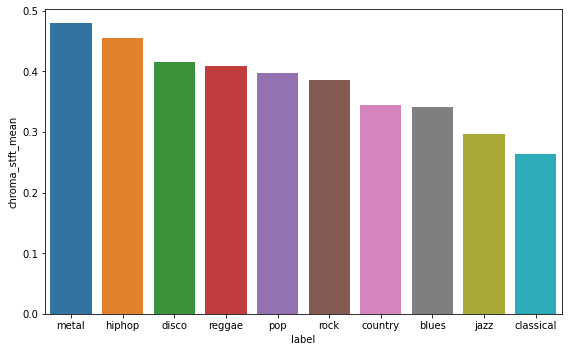

In [31]:
# Metal, hip-hop, and disco seem to have the highest pitch. The analysis matches what one could expect,
# especially since metal has a lot of high-pitch screams. Hip-hop might seem weird at first, but it makes
# sense because hip-hop heavily leverages pretty high-pitch synths. 

plot_feature(m30df, 'chroma_stft_mean')

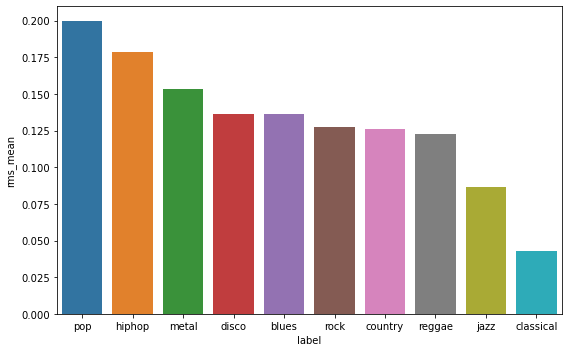

In [32]:
plot_feature(m30df, 'rms_mean')

In [ ]:
## Sweet!